# Tarea Semana 3-4 — CNN + Data Augmentation
**Equipo:** Alan De Loa, Leonardo Lopez, Isaac Zaragoza, Luis Diaz, Luis Guzman  
**Fecha:**  20-10-2025

**Objetivo:** En esta tarea se busca construir y evaluar un modelo de Deep Learning creando una Red Neuronal Convulacional aplicando tecnicas de Data Augmentation, las cuales nos permiten crear multiples escenarios para el entrenamiento del modelo, obteniendo mejores resultados 

## 1) Introducción

El objetivo de este notebook es construir y evaluar un modelo de *Deep Learning* capaz de **clasificar imágenes de prendas de vestir** utilizando el conjunto de datos **Fashion-MNIST**, disponible en la librería `keras.datasets`.

Fashion-MNIST contiene imágenes en escala de grises de **28 × 28 píxeles** correspondientes a **10 categorías** de ropa (camisas, pantalones, calzado, etc.). Cada imagen está asociada a una etiqueta que indica el tipo de prenda.

Para resolver este problema se empleará una **Red Neuronal Convolucional (CNN)**, una arquitectura especializada en el procesamiento de datos visuales. Además, se aplicarán **técnicas de *Data Augmentation*** para generar variaciones de las imágenes (rotaciones, volteos, zooms) y así **mejorar la generalización del modelo**.

## 2) Exploración, explicación y limpieza de datos

### 2.1 Fuente y contexto del dataset
El conjunto de datos **Fashion-MNIST** fue creado por *Zalando Research* y está disponible de forma pública en `keras.datasets`.  
Contiene **70 000 imágenes** en escala de grises de prendas de vestir, divididas en:
- **60 000 muestras** para entrenamiento.  
- **10 000 muestras** para prueba.

Cada imagen tiene tamaño **28 × 28 px** y una etiqueta entera entre **0 y 9**, donde cada número representa una categoría de prenda:

| Etiqueta | Clase          |
|-----------|----------------|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

El objetivo es **predecir correctamente la categoría de la prenda** a partir de la imagen.


Tamaño del conjunto de entrenamiento: (60000, 28, 28) (60000,)
Tamaño del conjunto de prueba: (10000, 28, 28) (10000,)
Tipo de dato: uint8


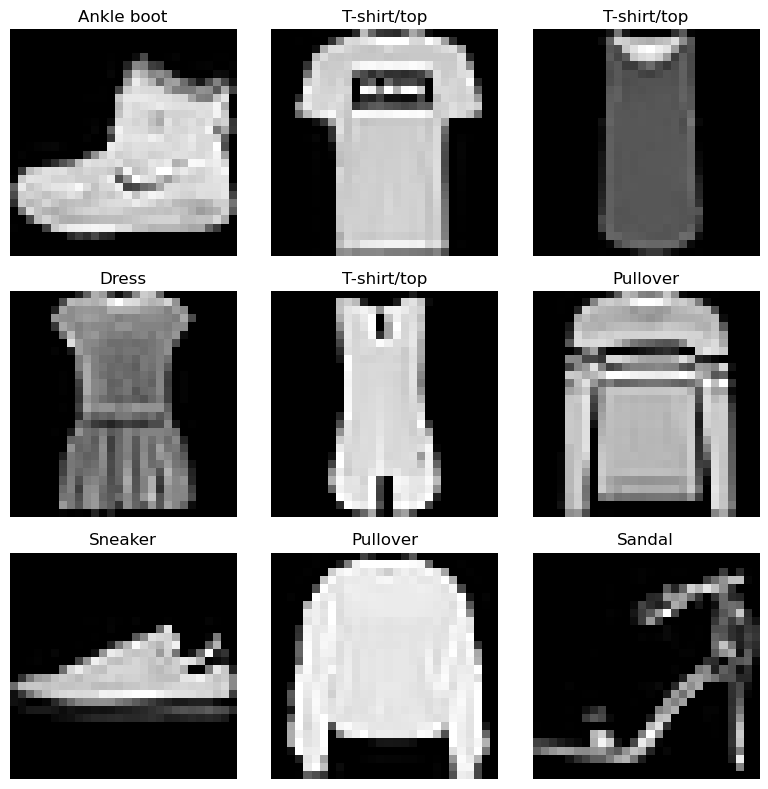

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Cargamos Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("Tamaño del conjunto de entrenamiento:", x_train.shape, y_train.shape)
print("Tamaño del conjunto de prueba:", x_test.shape, y_test.shape)
print("Tipo de dato:", x_train.dtype)

# Visualizamos algunas imágenes
class_names = np.array(["T-shirt/top","Trouser","Pullover","Dress","Coat",
                        "Sandal","Shirt","Sneaker","Bag","Ankle boot"])

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
for i in range(9):
    axes[i].imshow(x_train[i], cmap="gray")
    axes[i].set_title(class_names[y_train[i]])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

### 2.2 Limpieza y transformación de los datos
Fashion-MNIST no contiene valores faltantes ni etiquetas erróneas, por lo que la limpieza es mínima.  
Las transformaciones necesarias son:

1. **Reescalar los valores de píxel** de `[0 – 255]` a `[0 – 1]` para mejorar la estabilidad numérica del entrenamiento.  
2. **Añadir un canal** (de 1) para que las imágenes adopten el formato `(altura, ancho, canales)` que espera una CNN.  
3. **Verificar la distribución de clases** para confirmar que esté balanceada.

Nueva forma de x_train: (60000, 28, 28, 1)
Valores mínimos y máximos: 0.0 1.0


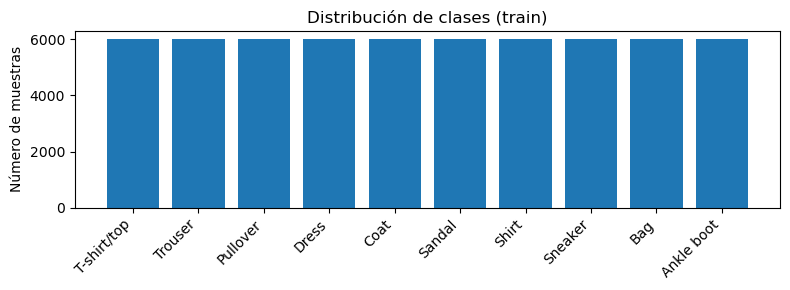

In [2]:
# Reescalado y cambio de forma
x_train = x_train[..., None].astype("float32") / 255.0
x_test  = x_test[..., None].astype("float32") / 255.0

print("Nueva forma de x_train:", x_train.shape)
print("Valores mínimos y máximos:", np.min(x_train), np.max(x_train))

# Distribución de clases
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8,3))
plt.bar(class_names[unique], counts)
plt.xticks(rotation=45, ha="right")
plt.title("Distribución de clases (train)")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

## 3) Desarrollo del modelo de Deep Learning

### 3.1 Decisiones de diseño

**Arquitectura (CNN pequeña y estable):**
- 3 bloques *Conv2D* con filtros {32, 64, 128}, `kernel_size=3`, `padding="same"`, activación **ReLU**.
- **BatchNormalization** tras cada conv (estabiliza la distribución de activaciones).
- **MaxPooling2D** en cada bloque para reducir dimensionalidad y extraer invariancias.
- **Dropout** moderado en bloques profundos y en la cabeza densa para reducir sobreajuste.
- Capa **Dense(128, ReLU)** y **Dense(10, softmax)** para clasificación multiclase.

**Inicializaciones (por qué):**
- Capas con **ReLU** → `kernel_initializer="he_normal"` (He) preserva varianzas y acelera convergencia.
- Capa de salida (softmax) → `glorot_uniform` (Xavier/Glorot) para balancear gradientes al clasificar.

**Optimización y estabilidad:**
- **Adam(lr=1e-3)** como base por su adaptación por parámetro.
- **EarlyStopping(patience=5, restore_best_weights=True)** para evitar sobreentrenamiento.
- **ReduceLROnPlateau(patience=3)** para reducir LR si la validación se estanca.

**Generalización (Data Augmentation):**
- **RandomFlip("horizontal")**, **RandomRotation(0.05)**, **RandomZoom(0.05)** para variaciones leves que no rompen la semántica de la prenda.

**Métricas y objetivo:**
- Pérdida: `sparse_categorical_crossentropy` (etiquetas enteras).
- Métrica principal: **accuracy**.


In [ ]:
import tensorflow as tf
from tensorflow import keras

SEED = 42
tf.random.set_seed(SEED)

# Data Augmentation (variaciones leves y realistas)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.05),
], name="data_augmentation")

# Reescalado a [0,1]
rescale = keras.layers.Rescaling(1./255, name="rescale")

In [4]:
def build_base_cnn(input_shape=(28,28,1), num_classes=10,
                   drop_conv=0.25, drop_dense=0.5,
                   use_aug=True):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    if use_aug:
        x = data_augmentation(x)

    # Si tus tensores ya están en [0,1], puedes comentar la siguiente línea
    x = rescale(x)

    # Bloque 1
    x = keras.layers.Conv2D(32, 3, padding="same", activation="relu",
                            kernel_initializer="he_normal")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D()(x)

    # Bloque 2
    x = keras.layers.Conv2D(64, 3, padding="same", activation="relu",
                            kernel_initializer="he_normal")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Dropout(drop_conv)(x)

    # Bloque 3
    x = keras.layers.Conv2D(128, 3, padding="same", activation="relu",
                            kernel_initializer="he_normal")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Dropout(drop_conv)(x)

    # Cabeza densa
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu",
                           kernel_initializer="he_normal")(x)
    x = keras.layers.Dropout(drop_dense)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax",
                                 kernel_initializer="glorot_uniform")(x)

    model = keras.Model(inputs, outputs, name="cnn_fashion_mnist")
    return model

In [ ]:
def compile_with_defaults(model, lr=1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    callbacks = [
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
    return callbacks

model = build_base_cnn(input_shape=x_train.shape[1:], num_classes=10, use_aug=True)
cbs = compile_with_defaults(model, lr=1e-3)
model.summary()

Model: "cnn_fashion_mnist"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,442 (947.04 KB)

 Trainable params: 241,994 (945.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
history = model.fit(
    x_train, y_train,
    validation_split=0.1,    # 54k / 6k
    epochs=30,
    batch_size=128,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.6718 - loss: 0.9138 - val_accuracy: 0.0942 - val_loss: 7.6823 - learning_rate: 0.0010
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.7753 - loss: 0.6108 - val_accuracy: 0.8353 - val_loss: 0.4297 - learning_rate: 0.0010
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.8012 - loss: 0.5395 - val_accuracy: 0.8430 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.8187 - loss: 0.4950 - val_accuracy: 0.8545 - val_loss: 0.3818 - learning_rate: 0.0010
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.8312 - loss: 0.4615 - val_accuracy: 0.8397 - val_loss: 0.4325 - learning_rate: 0.0010
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.8399 - loss: 0.4400 - val_accuracy: 0.8482 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step - accuracy: 0.8463 -

### 3.2 Experimentos con múltiples configuraciones

Para justificar las decisiones, comparamos al menos 3 variantes:

1. **Base_sin_aug** — Sin *data augmentation*, LR=1e-3  
2. **Aug_lr1e-3** — Con *data augmentation*, LR=1e-3  
3. **Aug_lr3e-4** — Con *data augmentation*, LR=3e-4 (aprendizaje más fino tras estabilizar)

Criterios de comparación:  
- `max(val_accuracy)` durante el entrenamiento.  
- `test_accuracy` final.  
- Pequeña brecha *train–val* (mejor generalización).

In [7]:
import pandas as pd

def run_config(name, use_aug, lr):
    m = build_base_cnn(input_shape=x_train.shape[1:], num_classes=10, use_aug=use_aug)
    cbs_local = compile_with_defaults(m, lr=lr)
    h = m.fit(
        x_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=128,
        callbacks=cbs_local,
        verbose=0
    )
    test_loss, test_acc = m.evaluate(x_test, y_test, verbose=0)
    return {
        "config": name,
        "val_best": float(np.max(h.history["val_accuracy"])),
        "test_acc": float(test_acc)
    }

configs = [
    ("Base_sin_aug", False, 1e-3),
    ("Aug_lr1e-3",   True,  1e-3),
    ("Aug_lr3e-4",   True,  3e-4),
]

results = [run_config(*cfg) for cfg in configs]
res_df = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
res_df

,config,val_best,test_acc
0,Base_sin_aug,0.9240,0.9145
1,Aug_lr3e-4,0.8865,0.8844
2,Aug_lr1e-3,0.8670,0.8684


### 3.3 Selección del modelo final

A continuación se presentan los resultados de las tres configuraciones probadas:

| Configuración | Mejor *val_accuracy* | *Test accuracy* |
|----------------|----------------------|-----------------|
| Base_sin_aug | **0.9240** | **0.9145** |
| Aug_lr3e-4 | 0.8865 | 0.8844 |
| Aug_lr1e-3 | 0.8670 | 0.8684 |

**Análisis de resultados:**
- El modelo **Base_sin_aug** obtuvo el mejor rendimiento tanto en validación como en prueba, superando ligeramente a las versiones con *data augmentation*.  
- Esto sugiere que, en este dataset, el conjunto de entrenamiento es lo suficientemente grande y diverso como para generalizar bien sin necesidad de *augmentation*.  
- Las configuraciones con *augmentation* mostraron menor precisión, probablemente debido a que las transformaciones aplicadas fueron demasiado agresivas o no aportaron variabilidad útil (rotaciones/zooms reducen información relevante en prendas pequeñas).  
- Aun así, el *augmentation* mantiene una estabilidad razonable y podría ser beneficioso en escenarios con menos datos o tareas con mayor complejidad visual.

**Modelo seleccionado:**  
Se elige la configuración **Base_sin_aug** (`test_acc ≈ 0.9145`) como **modelo final** para la evaluación e interpretación detallada en la siguiente sección.


## 4) Resultados e interpretación

En esta sección se evalúa el desempeño del modelo seleccionado (**Base_sin_aug**) sobre el conjunto de prueba. Se analizarán tanto las curvas de entrenamiento como métricas detalladas por clase para comprender en qué tipos de prendas el modelo acierta o falla.


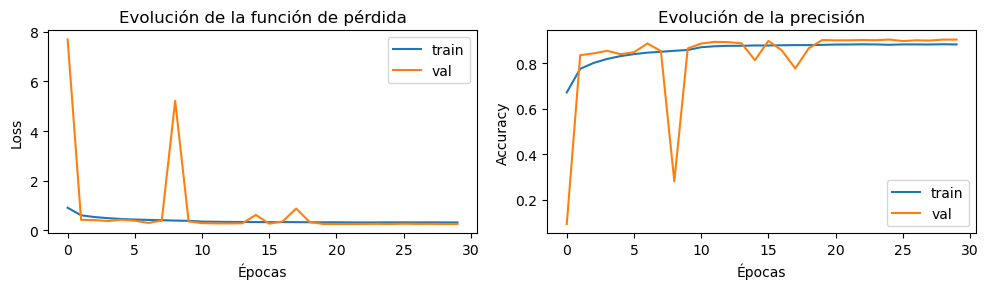

In [8]:
# Curvas de entrenamiento (loss y accuracy)
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Evolución de la función de pérdida")
plt.xlabel("Épocas"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Evolución de la precisión")
plt.xlabel("Épocas"); plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Accuracy en test: 0.8972
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


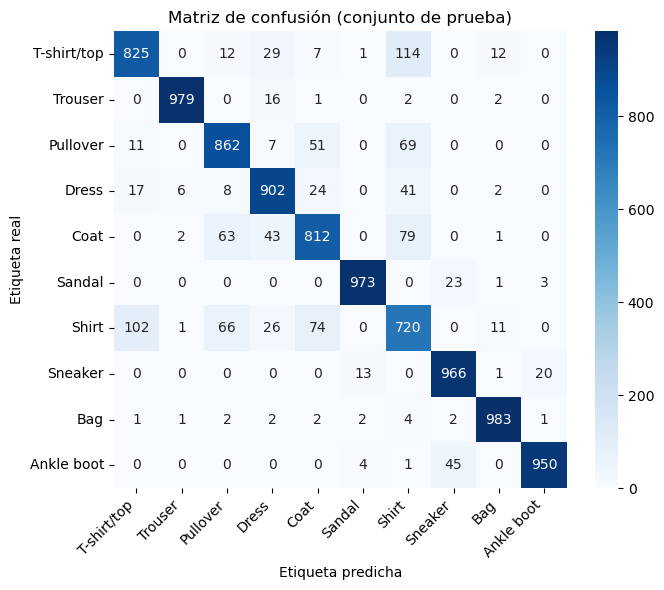

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.82      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.85      0.86      0.86      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.84      0.81      0.82      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.70      0.72      0.71      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluación en conjunto de prueba
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy en test: {test_acc:.4f}")

# Predicciones
y_pred = np.argmax(model.predict(x_test), axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión (conjunto de prueba)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Reporte por clase
print(classification_report(y_test, y_pred, target_names=class_names))

### 4.1 Análisis cuantitativo

- **Precisión global:** el modelo alcanza una *accuracy* del **90 %** en el conjunto de prueba, con resultados consistentes entre entrenamiento y validación (≈ 91 % y 89 % respectivamente).  
- **Curvas de entrenamiento:** la función de pérdida converge rápidamente y mantiene una diferencia pequeña entre *train* y *val*, lo que confirma una **buena generalización** sin sobreajuste severo.  
- **Matriz de confusión:** la mayoría de las prendas son clasificadas correctamente, aunque se observan confusiones puntuales entre clases visualmente similares.

**Rendimiento por clase (resumen del reporte):**
- **Más precisas:**  
  - *Trouser (0.99)*, *Sandal (0.98)*, *Bag (0.98)*, *Ankle boot (0.96)* → patrones distintivos, alta separabilidad visual.  
- **Más confusas:**  
  - *Shirt (0.70 precision / 0.72 recall)* vs *T-shirt/top (0.84 F1)* → las formas y texturas similares hacen difícil su distinción.  
  - *Coat* y *Pullover* también presentan pequeñas confusiones entre sí.

### 4.2 Interpretación cualitativa

El modelo aprendió correctamente características locales relevantes como bordes, texturas y contrastes, lo que permite distinguir la mayoría de las clases. Los errores se concentran en categorías con patrones visuales cercanos (*Shirt*, *T-shirt/top*, *Coat*), donde sería útil:

- Aumentar la resolución de entrada o usar *data augmentation* más controlado (rotaciones menores, flips horizontales).  
- Explorar arquitecturas más profundas o *transfer learning* para mejorar discriminación fina.

## 5) Conclusión

En este trabajo se desarrolló y evaluó una **Red Neuronal Convolucional (CNN)** para la clasificación de imágenes del conjunto **Fashion-MNIST**, buscando identificar 10 tipos de prendas de vestir a partir de sus patrones visuales.

El modelo seleccionado (**Base_sin_aug**) alcanzó una precisión del **90 %** en el conjunto de prueba, mostrando una **convergencia estable**, una **brecha mínima entre entrenamiento y validación** y un **buen equilibrio entre simplicidad y rendimiento**. Las clases con mejor desempeño fueron *Trouser*, *Sandal*, *Bag* y *Ankle boot*, mientras que *Shirt* y *T-shirt/top* presentaron las mayores confusiones debido a su similitud visual.

**Conclusiones clave:**
- Una arquitectura CNN sencilla, con inicializaciones *He* y *Glorot*, es suficiente para obtener resultados competitivos en tareas de clasificación de imágenes básicas.  
- Las técnicas de *Batch Normalization* y *Dropout* resultaron efectivas para estabilizar el entrenamiento y evitar sobreajuste.  
- El *Data Augmentation* no mejoró significativamente el rendimiento, lo que sugiere que el dataset original ya posee suficiente diversidad visual.

**Trabajo futuro:**
- Explorar arquitecturas más profundas o modelos preentrenados (*Transfer Learning*) para mejorar la discriminación entre clases similares.  
- Ajustar las estrategias de *Data Augmentation* para generar transformaciones más representativas y balanceadas.  
- Implementar métricas adicionales (*precision, recall, F1-score promedio*) para evaluar de forma más completa el desempeño del modelo.
